## Q-Table

### Construct environment by importing Frozen Lake Environment from OpenAI

In [1]:
# import library
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
env = gym.make("FrozenLake-v0")

In [7]:
# initialize Q-Table into zero
Q = np.zeros([env.observation_space.n, env.action_space.n])
lr = 0.8
y = 0.95
num_episodes = 2000

# create empty list of total reward
rList = []
for i in range(num_episodes):
    # reset environment and get new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    # Q-Table training algorithm
    while j < 99:
        j += 1
        # take greedy action from Q-Table
        a = np.argmax(Q[s, :] + np.random.randn(1, env.action_space.n) * (1./(i + 1)))
        # from environment get new state and reward
        s1, r, d, _ = env.step(a)
        # update Q-Table
        Q[s, a] = Q[s, a] + lr * (r + y * np.max(Q[s1, :]) - Q[s, a])
        rAll += r
        s = s1
        if d == True:
            break
    rList.append(rAll)

# rate of success episodes
print("Score over time : " + str(sum(rList)/num_episodes))

# print all values in Q-Table
print("Final Q-Table Values ")
print(Q)

Score over time : 0.4845
Final Q-Table Values 
[[8.54592830e-02 1.30705006e-02 1.27091029e-02 7.88757479e-03]
 [1.00403140e-03 3.43730813e-04 1.95368860e-04 1.99293679e-01]
 [1.51544714e-03 5.31994977e-03 1.51685267e-03 1.68154732e-01]
 [2.61311737e-05 7.87396878e-04 2.52985147e-04 8.41307603e-02]
 [1.12051680e-01 3.63715076e-03 5.81213204e-03 1.22247732e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.74500643e-01 1.61492363e-06 6.59347880e-04 1.77038197e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.17462575e-03 2.02762467e-03 5.37053247e-04 1.85034698e-01]
 [4.06894673e-03 5.55261481e-01 2.85291272e-03 0.00000000e+00]
 [8.54270985e-01 0.00000000e+00 2.00543725e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.68989564e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.94342337e-01]
 [0.0000

## Q-Network

In [8]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 

/home/ubuntu18/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu18/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu18/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu18/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

In [9]:
env = gym.make("FrozenLake-v0")

In [11]:
tf.reset_default_graph()

# feedforward of network(which will be use to choose action)
inputs1 = tf.placeholder(shape = [1, 16], dtype = tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)

# loss function, optimizer
nextQ = tf.placeholder(shape = [1, 4], dtype = tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
updateModel = trainer.minimize(loss)

# training network
init = tf.global_variables_initializer()

y = 0.99
e = 0.1
num_episodes = 2000

# create list which will contain total reward and num_steps of episode for each episode
jList = []  # num_steps
rList = []  # total_reward
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # Q-Network
        while j < 99:
            j += 1
            
            # select action greedy(random action with prob e)
            a, allQ = sess.run([predict, Qout], feed_dict = {inputs1 : np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            
            # obtain new state and reward from environment
            s1, r, d, _ = env.step(a[0])
            
            # calculate Q' according to feed new state in network
            Q1 = sess.run(Qout, feed_dict = {inputs1 : np.identity(16)[s1:s1+1]})
            
            # calculate max!' and set target value from selected action
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, a[0]] = r + y * maxQ1
            
            # train network by using target and predict Q value
            _, W1 = sess.run([updateModel, W], feed_dict = {inputs1 : np.identity(16)[s:s+1], nextQ : targetQ})
            rAll += r
            s = s1
            if d == True:
                # by training model, reduce probability of random action
                e = 1./((i/50) + 10)
                break
                
        jList.append(j)
        rList.append(r)
        
print("Percent of successful episodes : " + str(sum(rList)/num_episodes))

Percent of successful episodes : 0.4155


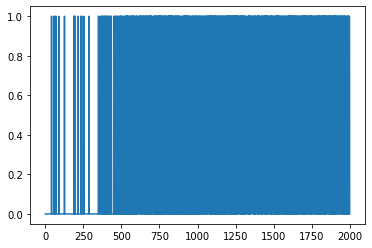

In [13]:
plt.plot(rList)

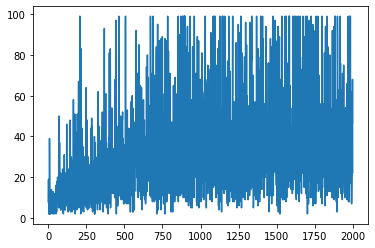

In [14]:
plt.plot(jList)